In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Train test split
from sklearn.model_selection import train_test_split

# Feature normalisation
from sklearn.preprocessing import StandardScaler

# Model hyperparameter tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.utils.class_weight import compute_sample_weight

# Models
import catboost as ctb

# Model Evaluation Section -----
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
df = pd.read_csv("../datasets/water_fe.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
# drivers = df[['quantity','longitude_imputation','latitude_imputation','gps_height','waterpoint_type_group',
#              'extraction_type_class','construction_decade','amount_tsh','payment_type']]

# drivers = df[['longitude_imputation','latitude_imputation','quantity','gps_height','extraction_type_class',
#              'waterpoint_type_group','payment_type','funder_grouped','amount_tsh','source_type','population_original','age']]

# drivers = df[['longitude_imputation','latitude_imputation','quantity','extraction_type_class','gps_height','age','waterpoint_type_group',
#              'population_original','payment_type','source_type','amount_tsh','funder_grouped','installer_grouped']]

drivers = df[['longitude_imputation','latitude_imputation','quantity','extraction_type_class','gps_height','age',
              'waterpoint_type_group','population_original','payment_type','source_type','funder_grouped',
              'basin','installer_grouped','management','water_quality','public_meeting']]
target = df['outcome']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(drivers, 
                                                    target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=42)

In [5]:
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test = scaler.fit_transform(X_test)

___
# <ins>Model Building<ins>

Learning rate set to 0.096348
0:	learn: 1.0325105	total: 144ms	remaining: 2m 24s
1:	learn: 0.9786480	total: 152ms	remaining: 1m 16s
2:	learn: 0.9374826	total: 162ms	remaining: 54s
3:	learn: 0.9007367	total: 169ms	remaining: 42.1s
4:	learn: 0.8702914	total: 177ms	remaining: 35.1s
5:	learn: 0.8455931	total: 183ms	remaining: 30.3s
6:	learn: 0.8235768	total: 191ms	remaining: 27.1s
7:	learn: 0.8056090	total: 199ms	remaining: 24.7s
8:	learn: 0.7889817	total: 207ms	remaining: 22.8s
9:	learn: 0.7745808	total: 215ms	remaining: 21.3s
10:	learn: 0.7620584	total: 222ms	remaining: 19.9s
11:	learn: 0.7514474	total: 229ms	remaining: 18.8s
12:	learn: 0.7424104	total: 236ms	remaining: 17.9s
13:	learn: 0.7348938	total: 243ms	remaining: 17.1s
14:	learn: 0.7264932	total: 250ms	remaining: 16.4s
15:	learn: 0.7198299	total: 257ms	remaining: 15.8s
16:	learn: 0.7142123	total: 265ms	remaining: 15.3s
17:	learn: 0.7083332	total: 272ms	remaining: 14.8s
18:	learn: 0.7028548	total: 279ms	remaining: 14.4s
19:	learn: 

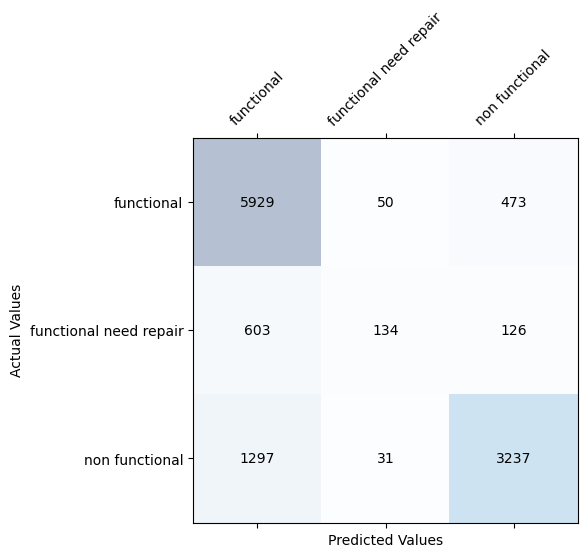

In [6]:
# Fit XGBoost Classification with the best parameter 
xgboost = ctb.CatBoostClassifier(loss_function='MultiClass',random_seed=42)

xgboost.fit(Xs_train, y_train)
y_pred =xgboost.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["functional","functional need repair","non functional"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

In [7]:
models = []
models.append(("XGBoost", xgboost))

# Test options and evaluation metric
num_folds = 5
num_instances = len(Xs_train)
scoring = "accuracy"
results = []
names = []

for name, model in models:
    kf = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, Xs_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
print("5-Fold cross-validation accuracy score for the training data for all the classifiers")

for name, cv_results in zip(names, results):
    print("%-15s: %.6f (%.6f)" % (name, cv_results.mean(), cv_results.std()))

5-Fold cross-validation accuracy score for the training data for all the classifiers
XGBoost        : 0.788426 (0.003065)
